## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

# from tvtk.api import tvtk
# from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config


### Brainmap plot configs

In [42]:
analysis_type = 'sm' #sm or ml
results_type = 'atlas' # atlas or software

### Global Vars

In [43]:
subject_ID_col = 'SubjID'

### Data paths

In [50]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
results_dir = proj_dir + 'data/results/'
stat_results_dir = results_dir + 'sm2/{}/'.format(results_type)
brainmaps_dir = stat_results_dir + 'brainmaps/'

common_space = proj_dir + 'code/compare-surf-tools/config/fsaverage/'
demograph_file = 'ABIDE_Phenotype.csv'


# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

outcome_var = 'roi' #'DX_GROUP'
predictor_var = 'AGE_AT_SCAN' #'DX_GROUP'
stat_measure = 'p_val_corr' # p_val or p_val_corr
stat_thresh = 0.05

if outcome_var == 'DX_GROUP':
    model_type = 'logit'
elif outcome_var in ['AGE_AT_SCAN','roi']:
    model_type = 'ols'
else:
    print('Unknown outcome variable {}'.format(outcome_var))

qc_list = ['No_QC','gleb','maarten','auto_low_dim','auto_high_dim']

if results_type == 'software':
    stat_perf_qc_concat = pd.DataFrame()
else:
    stat_perf_qc_concat = {}
    
for qc_type in qc_list:
    #pipelines_sm_perf_DKT_test_AGE_AT_SCAN_roi_ols_QC_manual_maarten_N_748.pkl
    if results_type == 'software':
        if qc_type == 'auto_low_dim':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_auto_low_dim_N_683.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'auto_high_dim':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_auto_high_dim_N_662.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'maarten':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_lenient_N_748.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_stringent_N_194.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_No_QC_N_778.pkl'.format(outcome_var,predictor_var,model_type)

    else: 
        if qc_type == 'auto_low_dim':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_auto_low_dim_N_959.pkl'.format(outcome_var,predictor_var,model_type)
        if qc_type == 'auto_high_dim':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_auto_high_dim_N_908.pkl'.format(outcome_var,predictor_var,model_type)   
        elif qc_type == 'maarten':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_lenient_N_975.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_stringent_N_225.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_No_QC_N_1047.pkl'.format(outcome_var,predictor_var,model_type)


    print('\nUsing following configs: \n outcome variable: {}\n predictor var: {}\n results_type: {}\n model_type: {}\n qc_type: {}\n'.format(outcome_var,
                                                                                                                        predictor_var,
                                                                                                                        results_type,
                                                                                                                        model_type,
                                                                                                                        qc_type))
    print('Perf file used: {}'.format(sm_perf_file))

    if stat_measure == 'p_val':
        mult_comp = 'no_FDR'
    elif stat_measure == 'p_val_corr':
        mult_comp = 'FDR'
    else:
        print('unknown multiple comparison correction')
        mult_comp = 'unknown'


    sm_perf_filename_split = sm_perf_file.rsplit('.',1)[0].rsplit('_',2) 
    #brainmap_subdir_prefix = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2] + '/'
    brainmap_subdir_prefix = '{}_{}_{}_{}/'.format(results_type,predictor_var,model_type,stat_measure)

    if results_type == 'software':
        stat_perf = pd.read_pickle(stat_results_dir + sm_perf_file)
        stat_perf['qc'] = qc_type
        stat_perf_qc_concat = stat_perf_qc_concat.append(stat_perf)

    else:
        with open(stat_results_dir + sm_perf_file, 'rb') as handle:
            stat_perf = pickle.load(handle)
    
        #stat_perf['qc'] = qc_type
        stat_perf_qc_concat[qc_type] = stat_perf


Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: No_QC

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_No_QC_N_1047.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: gleb

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_manual_stringent_N_225.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: maarten

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_manual_lenient_N_975.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: auto_low_dim

Perf file used: Atlas_FS6.0_sm_perf_roi_AGE_AT_SCAN_ols_QC_No_QC_N_1047.pkl

Using following configs: 
 outcome variable: roi
 predictor var: AGE_AT_SCAN
 results_type: atlas
 model_type: ols
 qc_type: auto_high_di

In [51]:
stat_perf_qc_concat.keys()

dict_keys(['No_QC', 'gleb', 'maarten', 'auto_low_dim', 'auto_high_dim'])

In [6]:
all_rois = set(stat_perf_qc_concat['roi'].unique())
for software in softwares:
    for aparc in aparcs:
        for qc in ['No_QC']:
            stat_df = stat_perf_qc_concat[(stat_perf_qc_concat['software']==software)&
                                              (stat_perf_qc_concat['qc']==qc)].copy()
            signific_rois = stat_df[stat_df[stat_measure] < stat_thresh]['roi'].values
            
            print('{} \n {}'.format(software,all_rois - set(signific_rois)))

NameError: name 'softwares' is not defined

In [7]:
stat_perf_qc_concat[stat_perf_qc_concat['roi']=='R_insula'].shape

(25, 7)

## PySurfer plots

In [52]:
# Plot configs

if results_type == 'software':
    softwares = list(stat_perf_qc_concat['software'].unique())
    qc_list = list(stat_perf_qc_concat['qc'].unique())
    aparcs = ['DKT']
    aparc = 'DKT'
    aparc_file = '.aparc.DKTatlas40.annot'
else:
    softwares = ['FS60']
    software = 'FS60' #For aggregating result cell 
    qc_list = list(stat_perf_qc_concat.keys())
    aparcs = list(stat_perf.keys()) #['aparc', 'Destrieux', 'Glasser']
    
# Pysurfer parameters
surf = 'inflated' #'white' #"inflated"
views = ['lateral','medial']

In [53]:
# Plot loops 

n_colors = 2
cmap = plt.get_cmap('Reds',n_colors)
plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
#plot_style = {'colormap':'icefire','center':0}

for software in softwares:
    for aparc in aparcs:
        for qc in qc_list:
            if results_type == 'software':            
                stat_df = stat_perf_qc_concat[(stat_perf_qc_concat['software']==software)&
                                              (stat_perf_qc_concat['qc']==qc)].copy()
                
            else:
                stat_perf = stat_perf_qc_concat[qc]
                stat_df = stat_perf[aparc]

            print('stat_df shape {}'.format(stat_df.shape))
            
            signific_rois = stat_df[stat_df[stat_measure] < stat_thresh]['roi'].values
#             signific_betas = stat_df[stat_df[stat_measure] < stat_thresh]['coef'].values
            
            signific_betas = np.ones(len(signific_rois)) ### Only coloring significant rois 
#             signific_betas = stat_df[stat_df[stat_measure] < stat_thresh]['rank'].values #for roi importance

            print('\nPipeline {}, parcellation {}, number of signficant ROIs {}'.format(software, aparc,len(signific_rois)))

            plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(signific_rois,aparc,signific_betas)
        
            if aparc == 'Glasser':
                aparc_file = '.HCP-MMP1.annot' 
            elif aparc == 'Destrieux':
                aparc_file = '.aparc.a2009s.annot' 
            elif aparc == 'aparc':
                aparc_file = '.aparc.annot'
            elif aparc in 'DKT':
                aparc_file = '.aparc.DKTatlas40.annot'
            else:
                aparc_file = ''
                print('Unknown cortical parcellation')

                
            save_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_{}/'.format(software, aparc,qc)
            for hemi in ['lh', 'rh']:
                if hemi=='lh':
                    signific_rois = plot_regions_L
                    betas = betas_L
                elif hemi=='rh':
                    signific_rois = plot_regions_R
                    betas = betas_R
                else: 
                    print('Unknown hemisphere parameter')

                for view in views:
                    title = '_{}_{}_{}_{}_{}_{}'.format(software,aparc,surf,hemi,view,stat_measure)
                    brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                                    save_dir,title,view,betas,plot_style)
                    time.sleep(5) #Mayavi messes up if called to quickly


stat_df shape (63, 5)

Pipeline FS60, parcellation DKT, number of signficant ROIs 60
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 30
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 1.0: 148906}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_No_QC/surf_FS60_DKT_inflated_lh_lateral_p_val_corr.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 30
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 1.0: 148906}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_No_QC/surf_FS60_DKT_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of 

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_auto_high_dim/surf_FS60_DKT_inflated_rh_lateral_p_val_corr.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 30
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14875, 1.0: 148967}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_DKT_auto_high_dim/surf_FS60_DKT_inflated_rh_medial_p_val_corr.png
stat_df shape (148, 5)

Pipeline FS60, parcellation Destrieux, number of signficant ROIs 140
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 69
atlas: .aparc.a2009s.annot, signficant roi count: {0.0: 22076, 1.0: 141766}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/res

number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 69
atlas: .aparc.a2009s.annot, signficant roi count: {0.0: 25101, 1.0: 138741}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_auto_high_dim/surf_FS60_Destrieux_inflated_lh_medial_p_val_corr.png
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 69
atlas: .aparc.a2009s.annot, signficant roi count: {0.0: 23285, 1.0: 140557}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_auto_high_dim/surf_FS60_Destrieux_inflated_rh_lateral_p_val_corr.png
number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 69
atlas: .aparc.a2009s.annot, signf

Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_low_dim/surf_FS60_Glasser_inflated_rh_medial_p_val_corr.png
stat_df shape (360, 5)

Pipeline FS60, parcellation Glasser, number of signficant ROIs 334
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 167
atlas: .HCP-MMP1.annot, signficant roi count: {0.0: 23517, 1.0: 140325}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_auto_high_dim/surf_FS60_Glasser_inflated_lh_lateral_p_val_corr.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 167
atlas: .HCP-MMP1.annot, signficant roi count: {0.0: 23517, 1.0: 140325}
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/dat

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Glasser_maarten/
Found 4 images
montage size (440, 440)


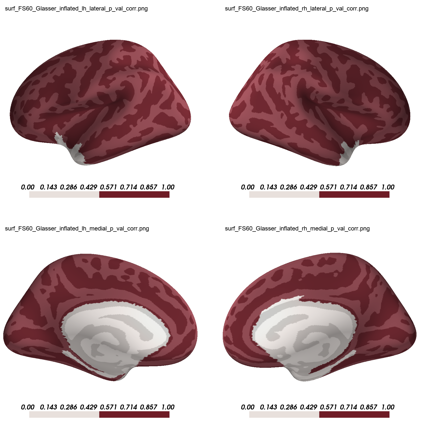

In [81]:
software = 'FS60'
qc = 'maarten'
aparc = 'Glasser'#'DKT' #'Destrieux' #'Glasser'
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_{}/'.format(software, aparc, qc)
montage_im = createSingleImageMontage(plot_dir)
montage_im

### Aggregate results

In [74]:
# w.r.t. QC for atlas
for aparc in aparcs:
    print('\nAggregating QC perf for {}'.format(aparc))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    df_aparc_concat = pd.DataFrame()
    for qc in stat_perf_qc_concat.keys():
        df_aparc = stat_perf_qc_concat[qc][aparc]
        df_aparc['aparc'] = aparc
        df_aparc_concat = df_aparc_concat.append(df_aparc)
    
    if aparc == 'Glasser':
        aparc_file = '.HCP-MMP1.annot' 
    elif aparc == 'Destrieux':
        aparc_file = '.aparc.a2009s.annot' 
    elif aparc == 'aparc':
        aparc_file = '.aparc.annot'
    elif aparc in 'DKT':
        aparc_file = '.aparc.DKTatlas40.annot'
    else:
        aparc_file = ''
        print('Unknown cortical parcellation')
        
    df_agg = aggregate_perf(df_aparc_concat,stat_measure,stat_thresh)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    #print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 QC ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)
    
   
    


Aggregating QC perf for DKT

 Number of signficant ROIs 63
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 3.0: 1608, 5.0: 147298}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr//FS60_DKT_qc_agg/surf_zagg_DKT_inflated_lh_lateral_p_val_corr_FS60.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14936, 3.0: 1608, 5.0: 147298}
colormap sequential: [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr//FS60_DKT_qc_agg/surf_zagg_DKT_inflated_lh_medial_p_val_corr_FS60.png
number of total vertices 163842 and ROIs 36
Using betas as colormap

In [ ]:
# w.r.t. QC for software

for software in stat_perf_qc_concat['software'].unique():
    print('\nAggregating QC perf for {}'.format(software))
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/{}_{}_qc_agg/'.format(software,aparc)
    a = stat_perf_qc_concat[stat_perf_qc_concat['software']==software].copy()

    df_agg = aggregate_perf(a,stat_measure,stat_thresh)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    #print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 QC ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/atlas/brainmaps/atlas_AGE_AT_SCAN_ols_p_val_corr/FS60_Destrieux_qc_agg/
Found 4 images
montage size (440, 440)


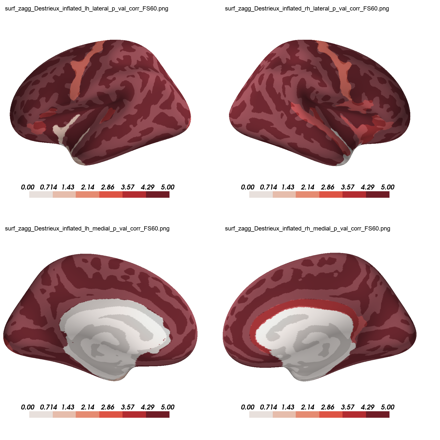

In [78]:
software = 'FS60'
aparc = 'Destrieux'#'DKT' #'Destrieux' #'Glasser'
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '{}_{}_qc_agg/'.format(software,aparc)
montage_im = createSingleImageMontage(plot_dir)
montage_im

In [19]:
#w.r.t pipeline
if results_type == 'software':
    save_dir = brainmaps_dir + brainmap_subdir_prefix + '/software_agg/'
    ()
    stat_perf_software = stat_perf_qc_concat[stat_perf_qc_concat['qc']=='No_QC'].copy()

    df_agg = aggregate_perf(stat_perf_software,stat_measure,stat_thresh)
    
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)


 Number of signficant ROIs 62
plot regions 
left: ['cuneus', 'parahippocampal', 'caudalmiddlefrontal', 'insula', 'superiortemporal', 'inferiortemporal', 'lateraloccipital', 'medialorbitofrontal', 'parsopercularis', 'entorhinal', 'caudalanteriorcingulate', 'precuneus', 'isthmuscingulate', 'parstriangularis', 'fusiform', 'supramarginal', 'transversetemporal', 'parsorbitalis', 'middletemporal', 'pericalcarine', 'precentral', 'inferiorparietal', 'superiorparietal', 'lateralorbitofrontal', 'superiorfrontal', 'posteriorcingulate', 'paracentral', 'postcentral', 'rostralmiddlefrontal', 'rostralanteriorcingulate', 'lingual'], 
right: ['inferiortemporal', 'lateralorbitofrontal', 'insula', 'pericalcarine', 'precuneus', 'parstriangularis', 'isthmuscingulate', 'paracentral', 'lingual', 'fusiform', 'precentral', 'parahippocampal', 'superiorparietal', 'parsopercularis', 'medialorbitofrontal', 'middletemporal', 'cuneus', 'supramarginal', 'superiorfrontal', 'rostralmiddlefrontal', 'postcentral', 'ento

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//software_agg/
Found 4 images
montage size (440, 440)


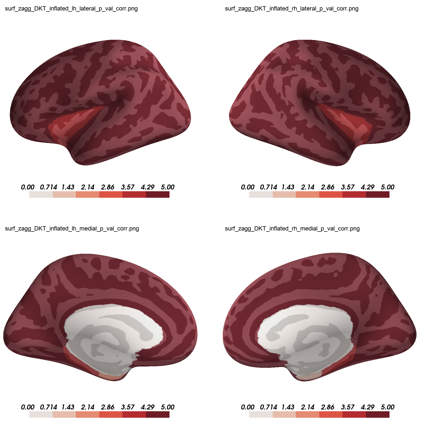

In [20]:
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '/software_agg/'
montage_im = createSingleImageMontage(plot_dir)
montage_im

In [21]:
# w.r.t  QC and software
# w.r.t. QC

save_dir = brainmaps_dir + brainmap_subdir_prefix + '/qc_software_agg/'.format(software,aparc)

df_agg = aggregate_perf(stat_perf_qc_concat,stat_measure,stat_thresh)
agg_rois = df_agg['roi'].values
agg_betas = df_agg['rank'].values
print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
#print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

n_colors = 26 # for 0-5 QC and 0-5 software ranks
#cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
cmap = plt.get_cmap('Reds',n_colors)
plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
for hemi in ['lh','rh']:
    if hemi=='lh':
        signific_rois = plot_regions_L
        betas = betas_L
    elif hemi=='rh':
        signific_rois = plot_regions_R
        betas = betas_R
    else: 
        print('Unknown hemisphere parameter')

    for view in views:
        title = '_{}_{}_{}_{}_{}_{}_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,software)
        brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                        save_dir,title,view,betas,plot_style)


 Number of signficant ROIs 62
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14125, 8.0: 811, 16.0: 1608, 20.0: 4791, 21.0: 4311, 22.0: 6536, 23.0: 52945, 24.0: 34455, 25.0: 44260}
colormap sequential: [0.00e+00, 1.25e+01, 2.50e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//qc_software_agg/surf_zagg_DKT_inflated_lh_lateral_p_val_corr_ANTs.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 31
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 14125, 8.0: 811, 16.0: 1608, 20.0: 4791, 21.0: 4311, 22.0: 6536, 23.0: 52945, 24.0: 34455, 25.0: 44260}
colormap sequential: [0.00e+00, 1.25e+01, 2.50e+01] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/sm2/software/brainmaps/software_AGE_AT_SCAN_ols_p_val_corr//qc_soft

Reading images from /home/nikhil/projects/CT_reproduce/data/results/sm2/brainmaps/Software_AGE_AT_SCAN_ols_p_val_corr//qc_software_agg/
Found 4 images
montage size (440, 440)


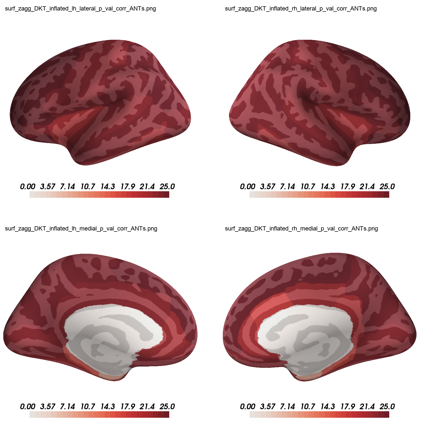

In [24]:
plot_dir = brainmaps_dir + brainmap_subdir_prefix + '/qc_software_agg/'
montage_im = createSingleImageMontage(plot_dir)
montage_im

(array([ 2.,  0.,  0.,  0.,  2.,  1.,  0.,  6., 24., 27.]),
 array([ 8. ,  9.7, 11.4, 13.1, 14.8, 16.5, 18.2, 19.9, 21.6, 23.3, 25. ]),
 <a list of 10 Patch objects>)

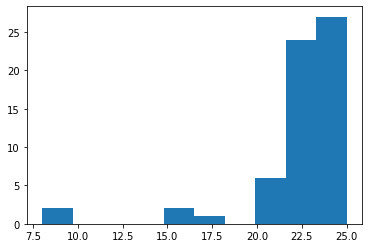

In [22]:
plt.hist(df_agg['rank'])